# Вступление
**Цель**: в рамках данного проекта я ставлю перед собой цель разработать модель, которая сможет точно классификаицировать овощи и фрукты, а также определять их свежесть/испорченность.

**Задачи проекта**:
1. Подготовка данных. Анализ распределения классов. Использование методов борьбы с несбалансированностью классов. Предварительная обработка данных, включая аугментацию изображений для улучшения устойчивости модели к изменениям в условиях съемки.
2. Выбор и настройка архитектуры нейронной сети для задачи классификации изображений. Разработка многоцелевой модели, способной одновременно определять вид продукта и его состояние (свежий или испорченный/несвежий).
3. Оптимизация и улучшение модели. 
4. Использование предобученных моделей. 
5. Оценка качества моделей на тестовом наборе данных. Проведение анализа ошибок моделей для выявления слабых мест. Выводы о применимости разработанной модели в реальных условиях и возможные пути дальнейшего улучшения.

**Описание датасета**:

Для реализации проекта был использован "Fresh and Rotten/Stale Fruits and Vegetables Classification Dataset" (https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification/data) — обширный набор данных, включающий изображения различных фруктов и овощей в двух состояниях: свежем и испорченном/несвежем. Датасет состоит из тысяч изображений, снятых при различных условиях освещения, углах и на разных фонах, что создает значительную вариативность и приближает задачу классификации к реальным условиям.

# Импорт библиотек
В данном проекте основным фреймворком для разработки и обучения нейронной сети выбран PyTorch.

In [93]:
import os
import cv2 as op
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sea
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sea.set_theme()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Загрузка данных

In [4]:
TRAIN_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Train'
TEST_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))
            
    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })
    
    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape
    

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

((23619, 3), (6738, 3))

# Подготовка данных

In [5]:
replacement_dict = {'tamto': 'tomato', 'patato': 'potato'}
df_test['fruit'] = df_test['fruit'].map(replacement_dict).fillna(df_test['fruit'])

## Балансировка классов

Как можно заметить из графиков, в тестовом датасете отсутствуют 2 из 9 классов, что есть в обучающем датасете. Удалять 2 класса из train мне бы не хотелось, так как тогда не удасться протестировать качество классифицирования этих классов. Поэтому я решила объединить обучаюшую и тестовую часть и сделать свое разбиение на train/validation/test.

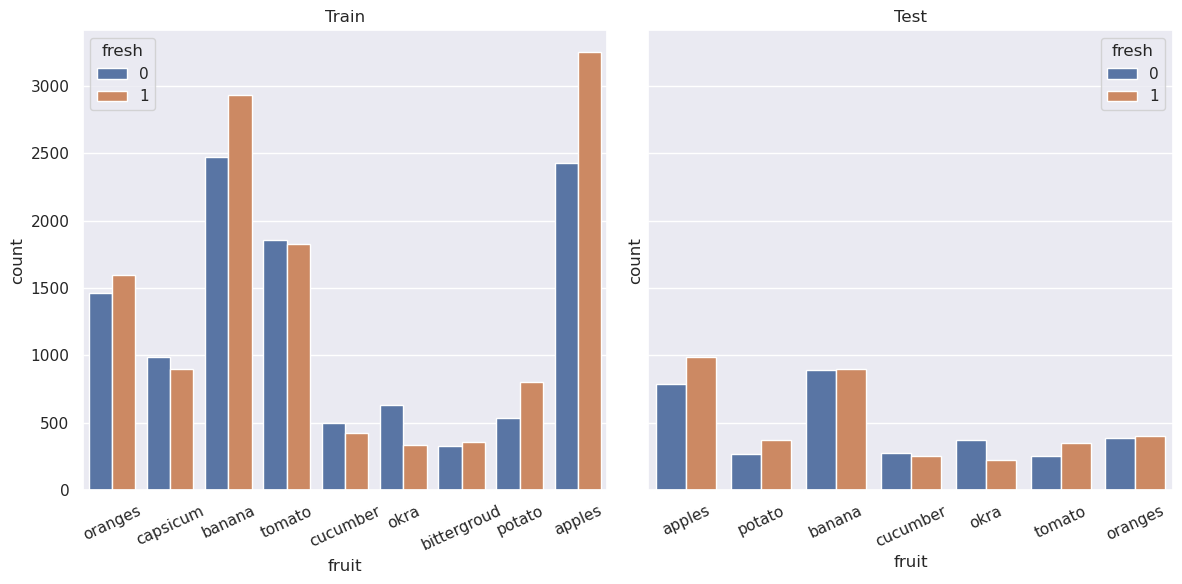

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sea.countplot(x='fruit', data=df_train, hue='fresh', ax=axes[0])
axes[0].set_title('Train')
axes[0].tick_params(axis='x', rotation=25)

sea.countplot(x='fruit', data=df_test, hue='fresh', ax=axes[1])
axes[1].set_title('Test')
axes[1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

In [7]:
df = pd.concat([df_train, df_test], axis = 0)

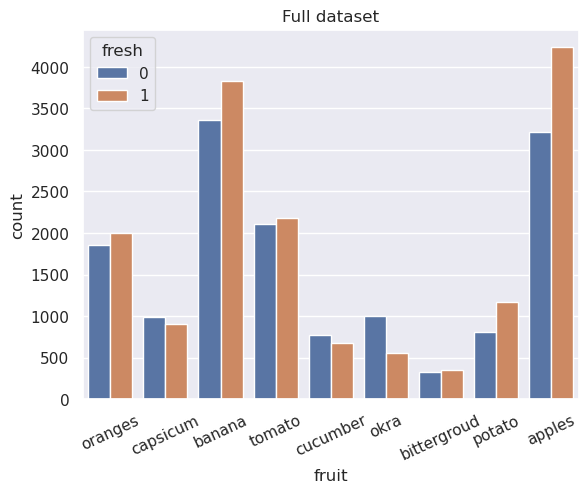

In [8]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')
plt.title('Full dataset')
plt.xticks(rotation=25)
plt.show()

Как видно из данных, датасет сильно несбалансирован. В нем много экземпляров классов apples и banana, при этом очень мало bitterground, cucumber, okra, capsicum и potato. Обучение модели на таких данных может значительно ухудшить её производительность и полезность, особенно в отношении классификации экземпляров редких классов. Поэтому я попробую сбалансировать классы. Для этого я сделаю downsampling для доминирующих классов, а  малочисленные классы оставлю, как есть. Выбрана граница в 2000 наблюдений.

In [9]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 2000:
        df_temp = df[df['fruit'] == key].sample(n = 2000)
    else:
        df_temp = df[df['fruit'] == key]
        
    df_new = pd.concat([df_new, df_temp], axis = 0)  
    
df_new.shape

(15571, 3)

In [10]:
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(15571, 4)

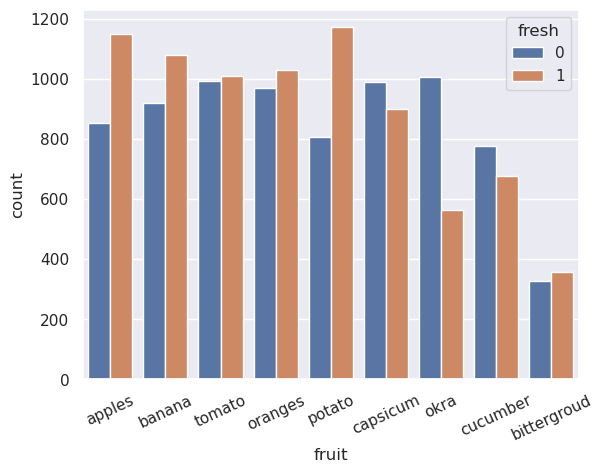

In [11]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')
plt.xticks(rotation=25)
plt.show()

## Деление train/validation/test

Разделим датасет в отношении 70/15/15

In [12]:
df_train, df_temp = train_test_split(df_new, test_size=0.3, stratify=df_new['fruit_label'])

df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['fruit_label'])

df_train.shape, df_val.shape, df_test.shape

((10899, 4), (2336, 4), (2336, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

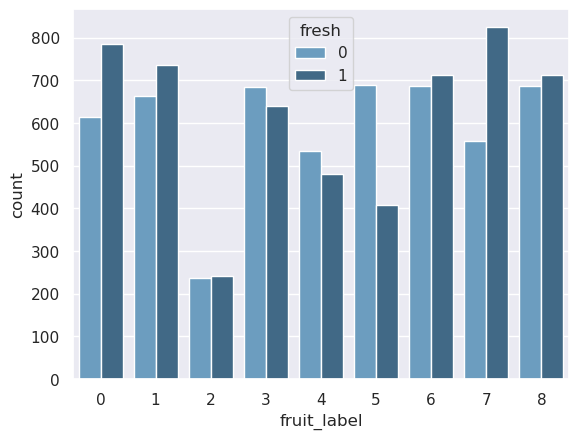

In [13]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

Посмотрим, как выглядят фотографии в датасете.

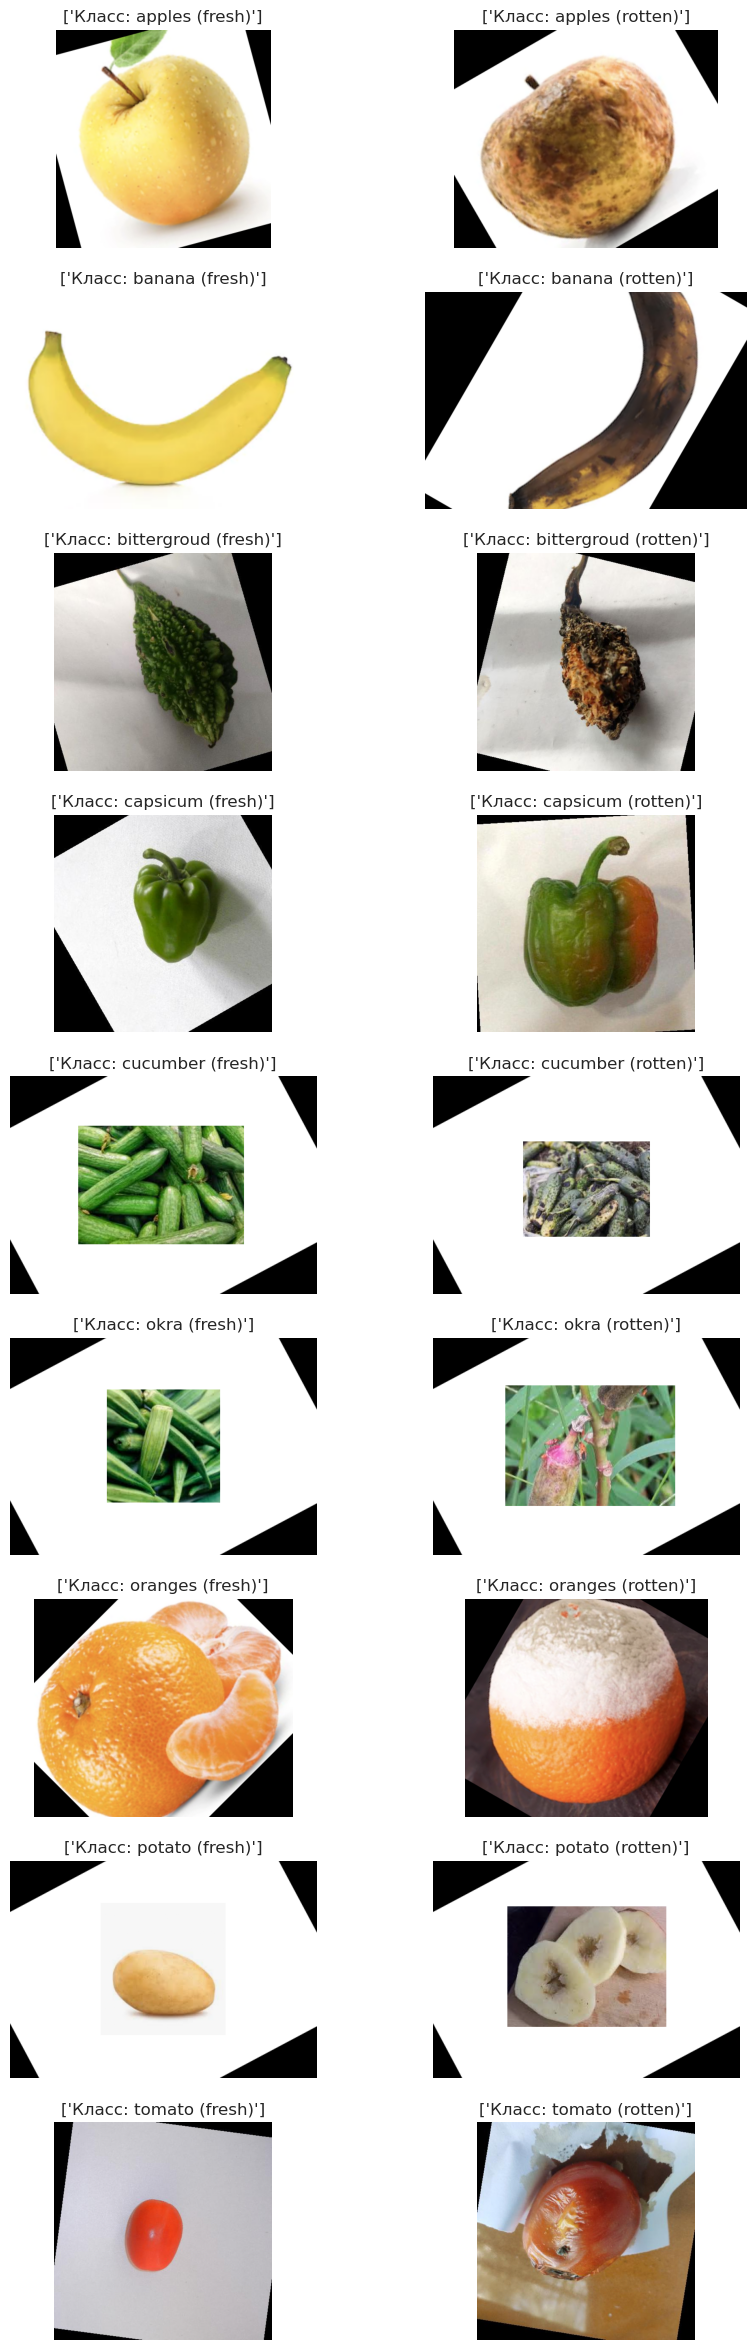

In [14]:
counter = 0

plt.figure(figsize=(10, 30))

for i in range(9):

    fresh_path = df_train[(df_train['fruit_label'] == i) & (df_train['fresh'] == 0)].sample(n=1)['filename'].values[0]
    rotten_path = df_train[(df_train['fruit_label'] == i) & (df_train['fresh'] == 1)].sample(n=1)['filename'].values[0]
    img1 = plt.imread(fresh_path)
    img2 = plt.imread(rotten_path)
    
    plt.subplot(9, 2, counter + 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.title('Класс: ' + le.inverse_transform([i]) + ' (fresh)')
    
    plt.subplot(9, 2, counter + 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.title('Класс: ' + le.inverse_transform([i]) + ' (rotten)')
    
    counter += 2

plt.show()

# Обучение модели

При аугментации данных использовались Random Horizontal, GaussianBlur and RandomAdjustSharpness. Изображения были приведены к размеру 224x224 для использования предобученных моделей.

In [15]:
def image_transform(img, p = 0.5, training = True):    
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)
            
        return img, fruit, fresh
    

In [16]:
BATCH_SIZE = 64

train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)


## Обучение baseline модель

Архитектура baseline модели

1. Архитектура представляет собой CNN с последовательными свёрточными и пулинговыми слоями для извлечения признаков, за которыми следуют два отдельных блока для классификации типа фрукта и свежести.
2. Эти блоки включают в себя два полносвязных слоя с активацией ReLU и Dropout. Выходной слой имеет количество нейронов, соответствующее количеству классов фрукта или свежести.
3. Для расчета потерь была взята взвешенная комбинация потерь из обеих ветвей ($\alpha=0.7$): $L_{total} = \alpha * L_{1} + (1 - \alpha) * L_{2}$

In [61]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes_fruit=9, num_classes_fresh=2):
        super(SimpleCNN, self).__init__()
        self.alpha = 0.7
        
        # Основная часть сети
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)

        # Первый блок для классификации фрукта
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes_fruit)
        )
        
        # Второй блок для классификации свежести
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes_fresh)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes_fruit)
        self.fresh_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes_fresh)
        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset) / BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset) / BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [], 
                        'train_acc_fruit': [], 'train_acc_fresh': [],
                        'val_acc_fruit': [], 'val_acc_fresh': []}
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.block2(x), self.block3(x)

    
    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis=1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis=1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis=1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis=1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
        
    def train(self, epochs=5):
        for epoch in tqdm(range(epochs)):
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history(train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(
                epoch, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh))



In [62]:
model = SimpleCNN(num_classes_fruit=9, num_classes_fresh=2).to(device)

In [63]:
model.train(epochs=12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 0] Train: [loss: 0.876, fruit: 0.608 fresh: 0.642] Val: [loss: 0.609, fruit: 0.719 fresh: 0.725]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.445, fruit: 0.814 fresh: 0.813] Val: [loss: 0.430, fruit: 0.803 fresh: 0.801]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.349, fruit: 0.853 fresh: 0.848] Val: [loss: 0.322, fruit: 0.859 fresh: 0.872]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.294, fruit: 0.875 fresh: 0.874] Val: [loss: 0.306, fruit: 0.872 fresh: 0.860]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.253, fruit: 0.894 fresh: 0.892] Val: [loss: 0.279, fruit: 0.879 fresh: 0.883]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.223, fruit: 0.906 fresh: 0.901] Val: [loss: 0.262, fruit: 0.887 fresh: 0.907]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.201, fruit: 0.913 fresh: 0.911] Val: [loss: 0.221, fruit: 0.909 fresh: 0.908]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.185, fruit: 0.921 fresh: 0.921] Val: [loss: 0.208, fruit: 0.916 fresh: 0.923]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.162, fruit: 0.932 fresh: 0.930] Val: [loss: 0.211, fruit: 0.915 fresh: 0.926]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.154, fruit: 0.939 fresh: 0.927] Val: [loss: 0.179, fruit: 0.938 fresh: 0.927]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.131, fruit: 0.947 fresh: 0.944] Val: [loss: 0.183, fruit: 0.933 fresh: 0.923]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.118, fruit: 0.955 fresh: 0.945] Val: [loss: 0.160, fruit: 0.938 fresh: 0.935]


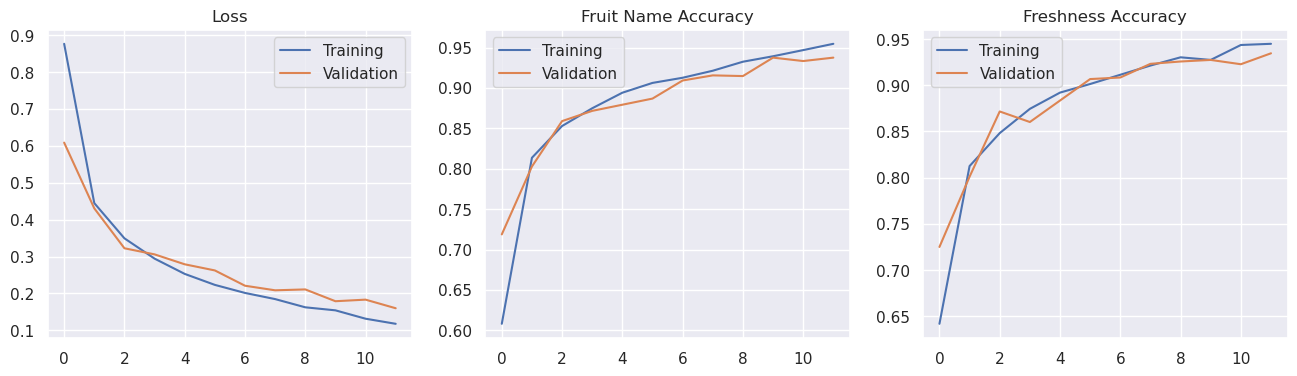

In [64]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model.history['train_loss'], label = 'Training')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model.history['train_acc_fruit'], label = 'Training')
plt.plot(model.history['val_acc_fruit'], label = 'Validation')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model.history['train_acc_fresh'], label = 'Training')
plt.plot(model.history['val_acc_fresh'], label = 'Validation')
plt.legend()

**Выводы**:
* Даже такая несложная сеть хорошо выполняет поставленную задачу. На train качество классификации овощей и фруктов достигает 0.95, определение их свежесть/испорченность - 0.94. На валидации 0.94 и 0.93 соответственно.
* Возможно, стоит рассмотреть добавление дополнительных слоёв (например, Batch Normalization или больше слоёв Dropout) для регуляризации и улучшения обобщающей способности модели.
* Можно попробовать углубить сеть, чтобы повысить качество.


## Эксперимент с базовой моделью

Внесем следующее изменение: добавим Batch Normalization после сверточных слоев.

In [83]:
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes_fruit=9, num_classes_fresh=2, learning_rate=3e-4):
        super(SimpleCNN_2, self).__init__()
        self.alpha = 0.7
        
        # Основная часть сети
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  
        
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)

        # Первый блок для классификации фрукта
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),  
            nn.Linear(128, num_classes_fruit)
        )
        
        # Второй блок для классификации свежести
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),  
            nn.Linear(32, num_classes_fresh)
        )

        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes_fruit)
        self.fresh_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes_fresh)

        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset) / BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset) / BATCH_SIZE)

        
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc_fruit': [], 'train_acc_fresh': [],
            'val_acc_fruit': [], 'val_acc_fresh': []
        }

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.block2(x), self.block3(x)

    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis=1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis=1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis=1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis=1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
    def train(self, epochs=5):
        for epoch in tqdm(range(epochs)):
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history(train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(
                epoch, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh))


In [84]:
model2 = SimpleCNN_2(num_classes_fruit=9, num_classes_fresh=2).to(device)

In [85]:
model2.train(epochs=12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 0] Train: [loss: 0.567, fruit: 0.769 fresh: 0.758] Val: [loss: 0.348, fruit: 0.864 fresh: 0.807]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.274, fruit: 0.890 fresh: 0.868] Val: [loss: 0.244, fruit: 0.900 fresh: 0.891]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.214, fruit: 0.912 fresh: 0.898] Val: [loss: 0.222, fruit: 0.923 fresh: 0.885]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.185, fruit: 0.928 fresh: 0.917] Val: [loss: 0.217, fruit: 0.913 fresh: 0.908]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.156, fruit: 0.941 fresh: 0.928] Val: [loss: 0.167, fruit: 0.931 fresh: 0.921]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.140, fruit: 0.945 fresh: 0.934] Val: [loss: 0.192, fruit: 0.927 fresh: 0.927]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.116, fruit: 0.957 fresh: 0.945] Val: [loss: 0.130, fruit: 0.954 fresh: 0.945]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.091, fruit: 0.971 fresh: 0.954] Val: [loss: 0.123, fruit: 0.956 fresh: 0.946]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.080, fruit: 0.975 fresh: 0.957] Val: [loss: 0.140, fruit: 0.949 fresh: 0.948]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.080, fruit: 0.973 fresh: 0.959] Val: [loss: 0.115, fruit: 0.960 fresh: 0.953]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.075, fruit: 0.977 fresh: 0.959] Val: [loss: 0.112, fruit: 0.962 fresh: 0.952]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.053, fruit: 0.984 fresh: 0.971] Val: [loss: 0.117, fruit: 0.964 fresh: 0.957]


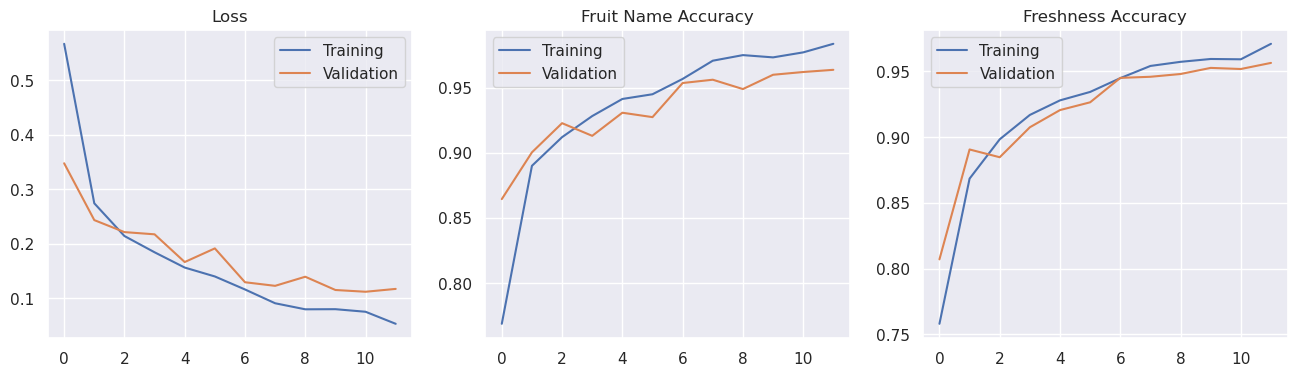

In [86]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model2.history['train_loss'], label = 'Training')
plt.plot(model2.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model2.history['train_acc_fruit'], label = 'Training')
plt.plot(model2.history['val_acc_fruit'], label = 'Validation')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model2.history['train_acc_fresh'], label = 'Training')
plt.plot(model2.history['val_acc_fresh'], label = 'Validation')
plt.legend()

**Выводы**:
* Качество модели выросло. На train accuracy по классификации овощей и фруктов достигает 0.98, определение их свежесть/испорченность - 0.97. На валидации примерно 0.96 по обеим задачам.
* Внесенные изменения действительно помогли улучшить модель.

## Модель на основе ResNet

Архитектура модели

1. Используем предобученную модель ResNet18.

2. Последний слой ResNet18 замеяем двумя полносвязаными слоями, а выходные данные аналогично отправляем в две ветви: первая ветвь предсказывает название фрукта, а другая ветвь предсказывает свежий фрукт или нет.

3. Последние 15 слоев ResNet18 были сделаны обучаемыми, а предыдущие слои были заморожены.

In [96]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7
        
        self.base = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
                    
        self.base.classifier = nn.Sequential() 
        self.base.fc = nn.Sequential() 
            
        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])
        
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)
        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [], 
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}
    
        
    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        
        return self.block2(x), self.block3(x)

    
    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        self.optimizer2.zero_grad()
        l1.backward(retain_graph = True)
        self.optimizer2.step()
        
        self.optimizer3.zero_grad()
        l2.backward(retain_graph = True)
        self.optimizer3.step()
        
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer1.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
        
    def train(self, epochs = 5):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh, 
                                                                                                                                          val_loss, val_fruit, val_fresh))


In [97]:
model3 = Model3().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s] 


In [98]:
model3.train(epochs = 12)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 0] Train: [loss: 0.609, fruit: 0.783 fresh: 0.773] Val: [loss: 0.185, fruit: 0.945 fresh: 0.902]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.144, fruit: 0.959 fresh: 0.919] Val: [loss: 0.106, fruit: 0.971 fresh: 0.941]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.091, fruit: 0.978 fresh: 0.940] Val: [loss: 0.089, fruit: 0.979 fresh: 0.951]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.071, fruit: 0.983 fresh: 0.954] Val: [loss: 0.070, fruit: 0.982 fresh: 0.960]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.058, fruit: 0.987 fresh: 0.963] Val: [loss: 0.061, fruit: 0.985 fresh: 0.963]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.048, fruit: 0.990 fresh: 0.966] Val: [loss: 0.054, fruit: 0.986 fresh: 0.972]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.038, fruit: 0.994 fresh: 0.971] Val: [loss: 0.047, fruit: 0.989 fresh: 0.971]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.030, fruit: 0.995 fresh: 0.977] Val: [loss: 0.046, fruit: 0.989 fresh: 0.973]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.028, fruit: 0.995 fresh: 0.980] Val: [loss: 0.047, fruit: 0.986 fresh: 0.977]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.022, fruit: 0.996 fresh: 0.982] Val: [loss: 0.033, fruit: 0.991 fresh: 0.978]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.022, fruit: 0.997 fresh: 0.981] Val: [loss: 0.036, fruit: 0.991 fresh: 0.981]


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.019, fruit: 0.998 fresh: 0.982] Val: [loss: 0.032, fruit: 0.992 fresh: 0.981]


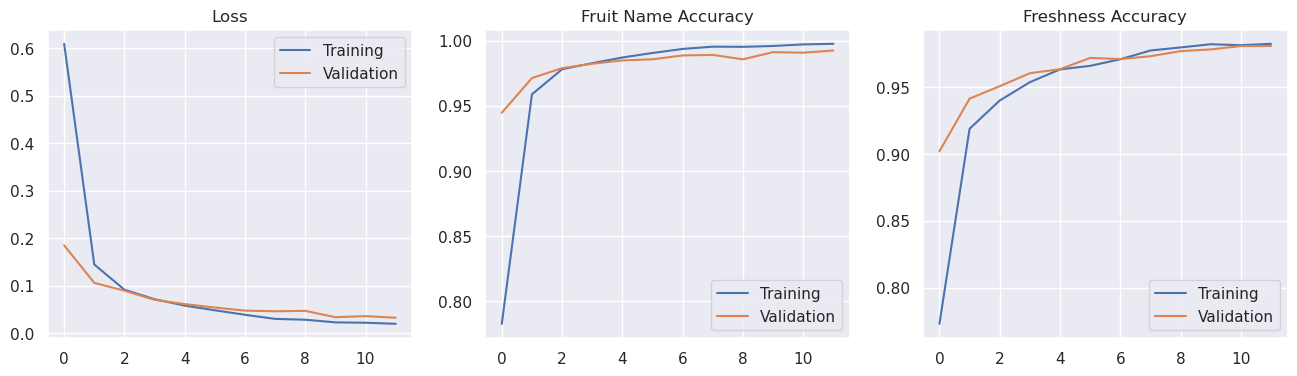

In [99]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model3.history['train_loss'], label = 'Training')
plt.plot(model3.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model3.history['train_acc_fruit'], label = 'Training')
plt.plot(model3.history['val_acc_fruit'], label = 'Validation')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model3.history['train_acc_fresh'], label = 'Training')
plt.plot(model3.history['val_acc_fresh'], label = 'Validation')
plt.legend()


**Выводы:**
* Дообучение ResNet позволяет почти идеально выполнять поставленную задачу.

# Качество на тестовом наборе

In [27]:
test_dataset = FruitDataset(df_test, training = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

## Baseline модель

In [80]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(test_loader):
        pred = model(x.to(device))
        
        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)
        
        
len(fruit), len(fresh), len(preds1), len(preds2)

  0%|          | 0/37 [00:00<?, ?it/s]

(2336, 2336, 2336, 2336)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

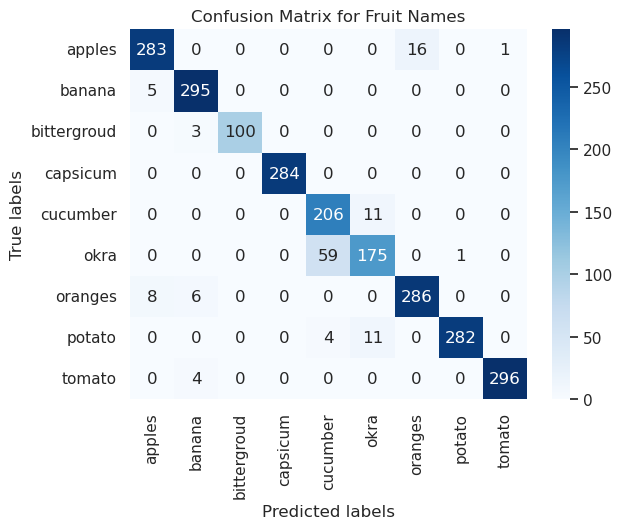

In [81]:
class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

Text(0.5, 1.0, 'Confusion Matrix for Freshness')

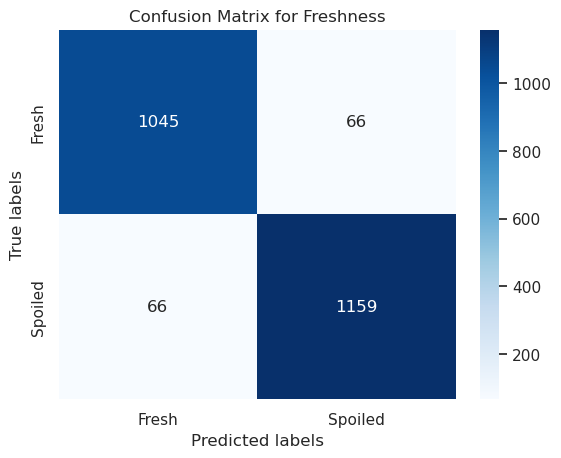

In [30]:
cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [82]:
print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.96      0.94      0.95       300
      banana       0.96      0.98      0.97       300
 bittergroud       1.00      0.97      0.99       103
    capsicum       1.00      1.00      1.00       284
    cucumber       0.77      0.95      0.85       217
        okra       0.89      0.74      0.81       235
     oranges       0.95      0.95      0.95       300
      potato       1.00      0.95      0.97       297
      tomato       1.00      0.99      0.99       300

    accuracy                           0.94      2336
   macro avg       0.95      0.94      0.94      2336
weighted avg       0.95      0.94      0.94      2336

              precision    recall  f1-score   support

       Fresh       0.95      0.93      0.94      1111
     Spoiled       0.93      0.96      0.95      1225

    accuracy                           0.94      2336
   macro avg       0.94      0.94      0.94      2336
weighted avg       0.94

## Улучшенная baseline модель

In [87]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(test_loader):
        pred = model2(x.to(device))
        
        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)
        
        
len(fruit), len(fresh), len(preds1), len(preds2)

  0%|          | 0/37 [00:00<?, ?it/s]

(2336, 2336, 2336, 2336)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

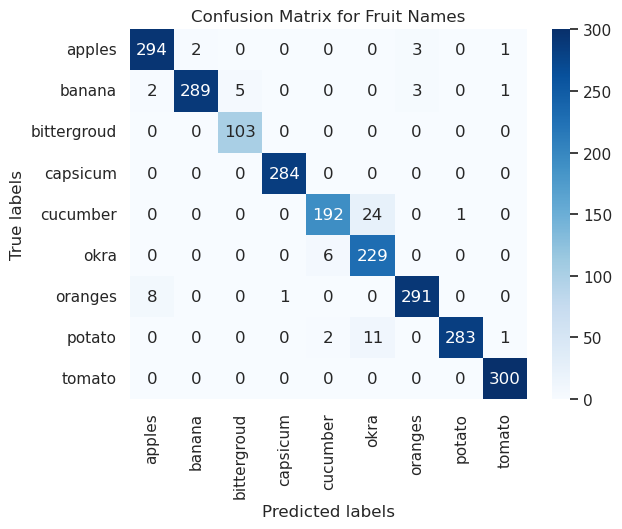

In [88]:
class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

Text(0.5, 1.0, 'Confusion Matrix for Freshness')

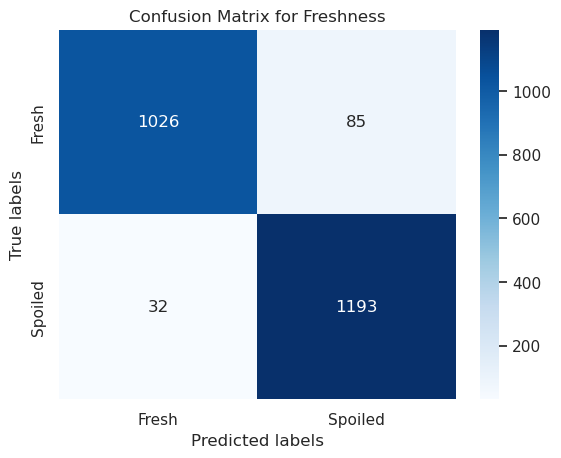

In [89]:
cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [90]:
print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.97      0.98      0.97       300
      banana       0.99      0.96      0.98       300
 bittergroud       0.95      1.00      0.98       103
    capsicum       1.00      1.00      1.00       284
    cucumber       0.96      0.88      0.92       217
        okra       0.87      0.97      0.92       235
     oranges       0.98      0.97      0.97       300
      potato       1.00      0.95      0.97       297
      tomato       0.99      1.00      1.00       300

    accuracy                           0.97      2336
   macro avg       0.97      0.97      0.97      2336
weighted avg       0.97      0.97      0.97      2336

              precision    recall  f1-score   support

       Fresh       0.97      0.92      0.95      1111
     Spoiled       0.93      0.97      0.95      1225

    accuracy                           0.95      2336
   macro avg       0.95      0.95      0.95      2336
weighted avg       0.95

## Модель на основе ResNet

In [100]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(test_loader):
        pred = model3(x.to(device))
        
        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)
        
        
len(fruit), len(fresh), len(preds1), len(preds2)

  0%|          | 0/37 [00:00<?, ?it/s]

(2336, 2336, 2336, 2336)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

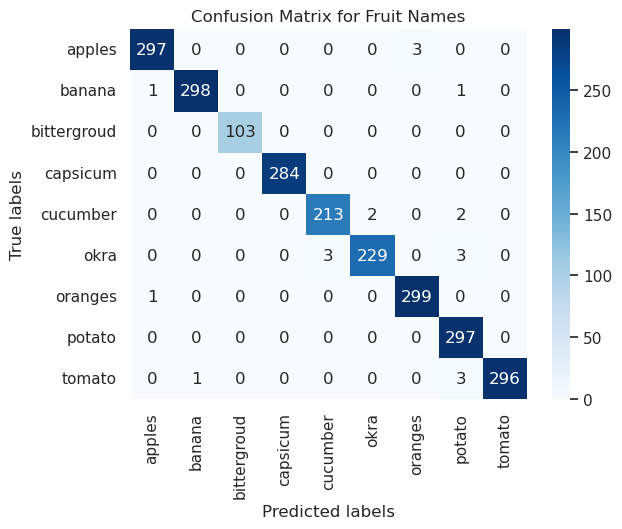

In [101]:
class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

Text(0.5, 1.0, 'Confusion Matrix for Freshness')

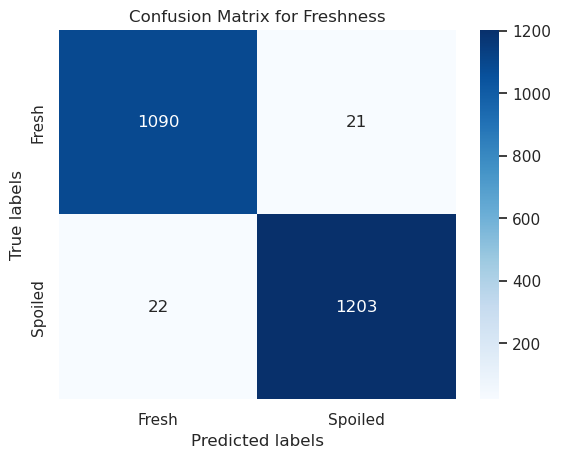

In [102]:
cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [103]:
print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.99      0.99      0.99       300
      banana       1.00      0.99      0.99       300
 bittergroud       1.00      1.00      1.00       103
    capsicum       1.00      1.00      1.00       284
    cucumber       0.99      0.98      0.98       217
        okra       0.99      0.97      0.98       235
     oranges       0.99      1.00      0.99       300
      potato       0.97      1.00      0.99       297
      tomato       1.00      0.99      0.99       300

    accuracy                           0.99      2336
   macro avg       0.99      0.99      0.99      2336
weighted avg       0.99      0.99      0.99      2336

              precision    recall  f1-score   support

       Fresh       0.98      0.98      0.98      1111
     Spoiled       0.98      0.98      0.98      1225

    accuracy                           0.98      2336
   macro avg       0.98      0.98      0.98      2336
weighted avg       0.98

# Выводы

1. Несложная CNN с последовательными свёрточными и пулинговыми слоями для извлечения признаков и двумя отдельными блоками для классификации типа фрукта и свежести показывает довольно хороший результат, достигая accuracy 0.94 в обеих. Однако, нужно отметить, что значения precision и recall низковаты у малочисленных классов cucumber и okra.

2. Добавление Batch Normalization после свёрточных слоёв повысило качество модели до accuracy 0.97 в первой задаче и 0.95 со второй. Также precision и recall у малочисленных классов стали выше. Видимо, эта модификация уменьшила переобучение и улучшила обобщающую способность модели.

3. Модель на основе ResNet дала наилучший результат, что неудивительно. ResNet, предобученная на больших наборах данных, таких как ImageNet, уже обладает знаниями о различных признаках, которые могут быть полезны и для моего набора данных. 

4. В задаче классификации фруктов и овощей эта модель достигла точности 0,99. Precision, Recall и F1-score тоже показывают, что модели рабоатет хорошо и не проседает в прогнозах отдельных классов. Даже малочисленные классы отлично предсказываются. Weighted Average - среднее значение метрик, взвешенное по количеству образцов в каждом классе, тоже на уровне 0,99.

5. При разделении свежих и испорченных фруктов модель правильно выполнила классифицию в 98% случаев. Precision, Recall и F1-score для обоих классов  тоже 0.98. В целом, модель продемонстрировала высокую эффективность.
